<a href="https://colab.research.google.com/github/Bryncs/Challenge_Data_Science_2_Alura/blob/main/InsightPlaces2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparando o Ambiente


## Instalando o Spark

In [2]:
!apt-get update -qq
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
!pip install -q findspark

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

In [4]:
import findspark
findspark.init()

In [5]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("Projeto InsighPlaces") \
    .config('spark.ui.port', '4050') \
    .getOrCreate()

In [6]:
spark

## Preparando o Drive

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importando os Dados

In [8]:
import zipfile

In [9]:
zipfile.ZipFile('/content/drive/MyDrive/insightPlaces2/semana-2.zip', 'r').extractall('/content/drive/MyDrive/insightPlaces2')

In [10]:
path = '/content/drive/MyDrive/insightPlaces2/dataset_transformado_parquet'
dados = spark.read.parquet(path)

# Seleção de Features

In [11]:
dados.printSchema()

root
 |-- id: string (nullable = true)
 |-- andar: long (nullable = true)
 |-- area_total: string (nullable = true)
 |-- area_util: string (nullable = true)
 |-- banheiros: long (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- quartos: long (nullable = true)
 |-- suites: long (nullable = true)
 |-- tipo_anuncio: string (nullable = true)
 |-- tipo_unidade: string (nullable = true)
 |-- tipo_uso: string (nullable = true)
 |-- vaga: long (nullable = true)
 |-- bairro: string (nullable = true)
 |-- zona: string (nullable = true)
 |-- condominio: string (nullable = true)
 |-- iptu: string (nullable = true)
 |-- tipo: string (nullable = true)
 |-- valor: string (nullable = true)



In [12]:
dados.show(5)

+--------------------+-----+----------+---------+---------+--------------------+-------+------+------------+------------+-----------+----+------------+------------+----------+----+-----+------+
|                  id|andar|area_total|area_util|banheiros|     caracteristicas|quartos|suites|tipo_anuncio|tipo_unidade|   tipo_uso|vaga|      bairro|        zona|condominio|iptu| tipo| valor|
+--------------------+-----+----------+---------+---------+--------------------+-------+------+------------+------------+-----------+----+------------+------------+----------+----+-----+------+
|03a386b6-7ab8-4ef...|    0|        43|       43|        1|[Churrasqueira, A...|      2|  null|       Usado| Apartamento|Residencial|   1|    Realengo|  Zona Oeste|       285|null|Venda| 22999|
|1fe78d41-b8e0-4d2...|    0|        44|       44|        1|                  []|      2|     0|       Usado| Apartamento|Residencial|   0|       Irajá|  Zona Norte|       170|   0|Venda|110000|
|1fa1c1e5-e98c-433...|    4|  

## Colunas com Apenas um Dado

Colunas filtradas anteriormente que contém apenas um dado

In [13]:
colunas_com_1_dado = ['tipo_anuncio', 'tipo_unidade', 'tipo_uso', 'tipo']

In [14]:
for col in colunas_com_1_dado:
  dados\
      .groupBy(col)\
      .count()\
      .orderBy('count', ascending = False)\
      .show()

+------------+-----+
|tipo_anuncio|count|
+------------+-----+
|       Usado|66562|
+------------+-----+

+------------+-----+
|tipo_unidade|count|
+------------+-----+
| Apartamento|66562|
+------------+-----+

+-----------+-----+
|   tipo_uso|count|
+-----------+-----+
|Residencial|66562|
+-----------+-----+

+-----+-----+
| tipo|count|
+-----+-----+
|Venda|66562|
+-----+-----+



In [15]:
dados.drop('tipo_anuncio', 'tipo_unidade', 'tipo_uso', 'tipo').printSchema()

root
 |-- id: string (nullable = true)
 |-- andar: long (nullable = true)
 |-- area_total: string (nullable = true)
 |-- area_util: string (nullable = true)
 |-- banheiros: long (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- quartos: long (nullable = true)
 |-- suites: long (nullable = true)
 |-- vaga: long (nullable = true)
 |-- bairro: string (nullable = true)
 |-- zona: string (nullable = true)
 |-- condominio: string (nullable = true)
 |-- iptu: string (nullable = true)
 |-- valor: string (nullable = true)



Retirando as colunas com apenas um dado

In [16]:
dados = dados.drop('tipo_anuncio', 'tipo_unidade', 'tipo_uso', 'tipo')

## Análisando os valores nulos e retirando colunas desnecessárias

In [17]:
from pyspark.sql import functions as f

In [18]:
valores_nulos = dados.drop('caracteristicas')

### Comparação de valores iguais entre area_total e area_util

In [19]:
valores_nulos\
    .select(f.count(f.when(valores_nulos.area_total == valores_nulos.area_util, True)).alias('valores_iguais'))\
    .show()

+--------------+
|valores_iguais|
+--------------+
|         55384|
+--------------+



area_total contém um número alto de dados nulos

In [20]:
valores_nulos\
    .select([f.count(f.when(f.isnan(c) | f.isnull(c), True)).alias(c) for c in valores_nulos.columns])\
    .show()

+---+-----+----------+---------+---------+-------+------+----+------+----+----------+----+-----+
| id|andar|area_total|area_util|banheiros|quartos|suites|vaga|bairro|zona|condominio|iptu|valor|
+---+-----+----------+---------+---------+-------+------+----+------+----+----------+----+-----+
|  0|    0|      9194|        0|        0|      0|  5554|3017|     0|   0|      2371|7199|    0|
+---+-----+----------+---------+---------+-------+------+----+------+----+----------+----+-----+



### Verificando coluna bairro

Número de dados distintos

In [21]:
dados\
    .select('bairro')\
    .distinct()\
    .count()

154

Dados que menos aparecem

In [22]:
dados\
    .groupBy('bairro')\
    .count()\
    .orderBy('count')\
    .show(5)

+----------------+-----+
|          bairro|count|
+----------------+-----+
|    Barros Filho|    1|
|Engenho do Porto|    1|
|      Grande Rio|    1|
|      Manguinhos|    1|
|Parque da Matriz|    1|
+----------------+-----+
only showing top 5 rows



Dados que mais aparecem

In [23]:
dados\
    .groupBy('bairro')\
    .count()\
    .orderBy('count', ascending = False)\
    .show(5)

+--------------------+-----+
|              bairro|count|
+--------------------+-----+
|     Barra da Tijuca|12788|
|Recreio dos Bande...| 7793|
|          Copacabana| 6784|
|         Jacarepaguá| 4437|
|              Tijuca| 3638|
+--------------------+-----+
only showing top 5 rows



- area_total retirado por ser muito parecida com area_util e conter muitos valores nulos
- bairro retirado por ter valores muito diferentes, alguns com muitos registros e outros com quase nenhum

In [24]:
dados = dados.drop('area_total', 'bairro')

In [25]:
dados.printSchema()

root
 |-- id: string (nullable = true)
 |-- andar: long (nullable = true)
 |-- area_util: string (nullable = true)
 |-- banheiros: long (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- quartos: long (nullable = true)
 |-- suites: long (nullable = true)
 |-- vaga: long (nullable = true)
 |-- zona: string (nullable = true)
 |-- condominio: string (nullable = true)
 |-- iptu: string (nullable = true)
 |-- valor: string (nullable = true)



# Convertendo os Tipos de Colunas

In [26]:
from pyspark.sql.types import DoubleType, IntegerType

In [27]:
dados.printSchema()

root
 |-- id: string (nullable = true)
 |-- andar: long (nullable = true)
 |-- area_util: string (nullable = true)
 |-- banheiros: long (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- quartos: long (nullable = true)
 |-- suites: long (nullable = true)
 |-- vaga: long (nullable = true)
 |-- zona: string (nullable = true)
 |-- condominio: string (nullable = true)
 |-- iptu: string (nullable = true)
 |-- valor: string (nullable = true)



In [28]:
dados = dados\
    .withColumn('andar', dados['andar'].cast(IntegerType()))\
    .withColumn('banheiros', dados['banheiros'].cast(IntegerType()))\
    .withColumn('suites', dados['suites'].cast(IntegerType()))\
    .withColumn('quartos', dados['quartos'].cast(IntegerType()))\
    .withColumn('area_util', dados['area_util'].cast(DoubleType()))\
    .withColumn('condominio', dados['condominio'].cast(DoubleType()))\
    .withColumn('iptu', dados['iptu'].cast(DoubleType()))\
    .withColumn('valor', dados['valor'].cast(DoubleType()))

# Tratamento dos Dados nulos e NaN's

Tranformação das listas vazias em valores nulos

In [29]:
dados = dados.withColumn('caracteristicas', f.when((f.size(f.col('caracteristicas')) == 0), f.lit(None)).otherwise(f.col('caracteristicas')))

Dando o valor aos dados nulos e Nan's

In [30]:
dados = dados\
    .select('*')\
    .na\
    .fill(0)

Retirado linhas sem valores da coluna zona

In [31]:
dados = dados\
    .where(f.col('zona') != '')

# Variáveis Dummy

In [32]:
dados.show(5)

+--------------------+-----+---------+---------+--------------------+-------+------+----+------------+----------+------+--------+
|                  id|andar|area_util|banheiros|     caracteristicas|quartos|suites|vaga|        zona|condominio|  iptu|   valor|
+--------------------+-----+---------+---------+--------------------+-------+------+----+------------+----------+------+--------+
|03a386b6-7ab8-4ef...|    0|     43.0|        1|[Churrasqueira, A...|      2|     0|   1|  Zona Oeste|     285.0|   0.0| 22999.0|
|1fe78d41-b8e0-4d2...|    0|     44.0|        1|                null|      2|     0|   0|  Zona Norte|     170.0|   0.0|110000.0|
|1fa1c1e5-e98c-433...|    4|     55.0|        1|                null|      2|     0|   1|  Zona Oeste|       0.0|   0.0|115000.0|
|a6ab01ae-3d40-40e...|    2|     55.0|        1|                null|      2|     0|   0|  Zona Norte|       0.0|   0.0|115000.0|
|1d8ff7a2-16bd-4e3...|    0|     50.0|        1|                null|      1|     0|   0|Z

Separando a coluna caracteristicas

In [33]:
caracteristicas = dados.select(dados.id, f.explode(dados.caracteristicas))
caracteristicas.show(5)

+--------------------+------------------+
|                  id|               col|
+--------------------+------------------+
|03a386b6-7ab8-4ef...|     Churrasqueira|
|03a386b6-7ab8-4ef...|          Academia|
|03a386b6-7ab8-4ef...|        Playground|
|03a386b6-7ab8-4ef...|   Salão de festas|
|03a386b6-7ab8-4ef...|Condomínio fechado|
+--------------------+------------------+
only showing top 5 rows



In [34]:
caracteristicas\
    .groupBy('col')\
    .count()\
    .show()

+------------------+-----+
|               col|count|
+------------------+-----+
|Condomínio fechado|34980|
|        Playground|31854|
| Portão eletrônico|29323|
|           Piscina|33235|
|Animais permitidos|30617|
|      Portaria 24h|30360|
|          Elevador|43023|
|          Academia|27641|
|   Salão de festas|33582|
|     Churrasqueira|31737|
+------------------+-----+



In [35]:
caracteristicas = caracteristicas\
    .groupBy('id')\
    .pivot('col')\
    .agg(f.lit(1))\
    .na\
    .fill(0)

In [36]:
zona = dados\
  .groupBy('id')\
  .pivot('zona')\
  .agg(f.lit(1))\
  .na\
  .fill(0)

In [37]:
dados = dados\
    .join(zona, 'id', how = 'inner')\
    .join(caracteristicas, 'id', how = 'inner')

In [38]:
dados = dados.drop('zona', 'caracteristicas', 'id')

In [39]:
dados.printSchema()

root
 |-- andar: integer (nullable = true)
 |-- area_util: double (nullable = false)
 |-- banheiros: integer (nullable = true)
 |-- quartos: integer (nullable = true)
 |-- suites: integer (nullable = true)
 |-- vaga: long (nullable = true)
 |-- condominio: double (nullable = false)
 |-- iptu: double (nullable = false)
 |-- valor: double (nullable = false)
 |-- Zona Central: integer (nullable = true)
 |-- Zona Norte: integer (nullable = true)
 |-- Zona Oeste: integer (nullable = true)
 |-- Zona Sul: integer (nullable = true)
 |-- Academia: integer (nullable = true)
 |-- Animais permitidos: integer (nullable = true)
 |-- Churrasqueira: integer (nullable = true)
 |-- Condomínio fechado: integer (nullable = true)
 |-- Elevador: integer (nullable = true)
 |-- Piscina: integer (nullable = true)
 |-- Playground: integer (nullable = true)
 |-- Portaria 24h: integer (nullable = true)
 |-- Portão eletrônico: integer (nullable = true)
 |-- Salão de festas: integer (nullable = true)



# Salvando em formato Parquet

No dataset há colunas com acento e letras maiusculas em seus nomes

In [40]:
nomes_antigos = dados.columns
nomes_antigos

['andar',
 'area_util',
 'banheiros',
 'quartos',
 'suites',
 'vaga',
 'condominio',
 'iptu',
 'valor',
 'Zona Central',
 'Zona Norte',
 'Zona Oeste',
 'Zona Sul',
 'Academia',
 'Animais permitidos',
 'Churrasqueira',
 'Condomínio fechado',
 'Elevador',
 'Piscina',
 'Playground',
 'Portaria 24h',
 'Portão eletrônico',
 'Salão de festas']

In [41]:
nomes_novos = [
    'andar',
    'area_util',
    'banheiros',
    'quartos',
    'suites',
    'vaga',
    'condominio',
    'iptu',
    'valor',
    'zona_central',
    'zona_norte',
    'zona_oeste',
    'zona_sul',
    'academia',
    'animais_permitidos',
    'churrasqueira',
    'condominio_fechado',
    'elevador',
    'piscina',
    'playground',
    'portaria_24h',
    'portao_eletronico',
    'salao_de_festas'
]

In [42]:
colunas_nomes = zip(nomes_antigos, nomes_novos)

In [43]:
for antigos, novos in colunas_nomes:
  dados = dados.withColumnRenamed(antigos, novos)

In [44]:
dados.columns

['andar',
 'area_util',
 'banheiros',
 'quartos',
 'suites',
 'vaga',
 'condominio',
 'iptu',
 'valor',
 'zona_central',
 'zona_norte',
 'zona_oeste',
 'zona_sul',
 'academia',
 'animais_permitidos',
 'churrasqueira',
 'condominio_fechado',
 'elevador',
 'piscina',
 'playground',
 'portaria_24h',
 'portao_eletronico',
 'salao_de_festas']

In [45]:
dados.write.parquet(
    path = '/content/drive/MyDrive/insightPlaces2/parquet',
    mode = 'overwrite'
)

# Vetorização dos Dados

In [46]:
dados = spark.read.parquet(
    '/content/drive/MyDrive/insightPlaces2/parquet'
)

In [47]:
from pyspark.ml.feature import VectorAssembler

In [48]:
dados = dados.withColumnRenamed('valor', 'label')

In [49]:
dados.columns

['andar',
 'area_util',
 'banheiros',
 'quartos',
 'suites',
 'vaga',
 'condominio',
 'iptu',
 'label',
 'zona_central',
 'zona_norte',
 'zona_oeste',
 'zona_sul',
 'academia',
 'animais_permitidos',
 'churrasqueira',
 'condominio_fechado',
 'elevador',
 'piscina',
 'playground',
 'portaria_24h',
 'portao_eletronico',
 'salao_de_festas']

In [50]:
X = [
    'andar',
    'area_util',
    'banheiros',
    'quartos',
    'suites',
    'vaga',
    'condominio',
    'iptu',
    'zona_central',
    'zona_norte',
    'zona_oeste',
    'zona_sul',
    'academia',
    'animais_permitidos',
    'churrasqueira',
    'condominio_fechado',
    'elevador',
    'piscina',
    'playground',
    'portaria_24h',
    'portao_eletronico',
    'salao_de_festas'
]

In [51]:
assembler = VectorAssembler(inputCols = X, outputCol = 'features')

In [52]:
dados_prep = assembler.transform(dados).select('features', 'label')

In [53]:
dados_prep.show(10, truncate = False)

+------------------------------------------------------------------------------------------------+--------+
|features                                                                                        |label   |
+------------------------------------------------------------------------------------------------+--------+
|[0.0,43.0,1.0,2.0,0.0,1.0,285.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0]    |22999.0 |
|(22,[0,1,2,3,5,6,10,13,14,15,17,19,21],[2.0,47.0,1.0,2.0,1.0,380.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|138000.0|
|(22,[1,2,3,5,6,10,14,15,17],[45.0,1.0,2.0,1.0,356.0,1.0,1.0,1.0,1.0])                           |140000.0|
|[3.0,48.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0]      |150000.0|
|[9.0,55.0,1.0,2.0,0.0,1.0,780.0,660.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0]  |160000.0|
|(22,[1,2,3,5,6,10,21],[70.0,2.0,2.0,1.0,420000.0,1.0,1.0])                                      |159000.0|
|(22,[0,1,2,3,6,7,9,13,15],[

# Análise de Correlação

In [54]:
from pyspark.ml.stat import Correlation
import pandas as pd

In [55]:
correlacao = Correlation.corr(dados_prep, 'features').collect()[0][0]

In [56]:
dataframe_correlacao = pd.DataFrame(correlacao.toArray(), columns = X, index = X)

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

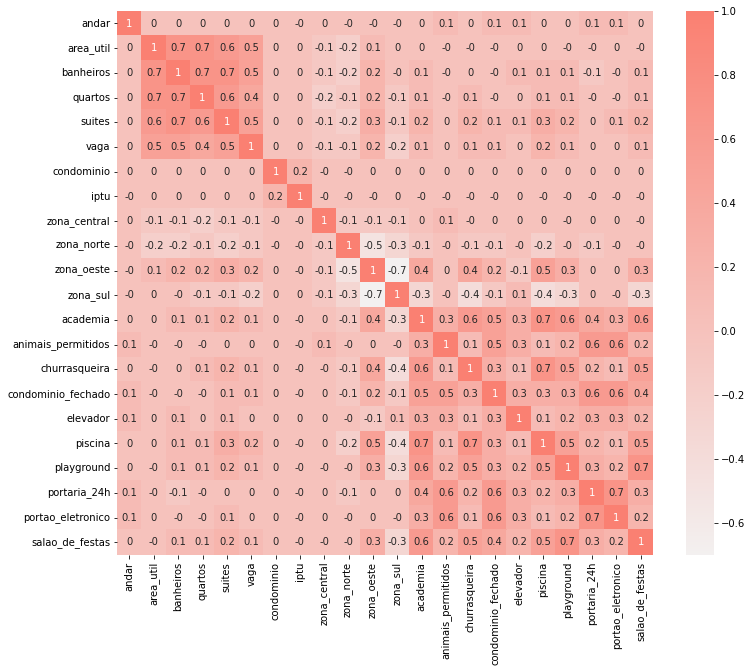

In [58]:
plt.figure(figsize = (12,10))
paleta = sns.color_palette('light:salmon', as_cmap = True)
sns.heatmap(dataframe_correlacao.round(1), annot = True, cmap = paleta)

# Regressão Linear

## Ajuste e Previsão

In [59]:
from pyspark.ml.regression import LinearRegression

In [60]:
treino, teste = dados_prep.randomSplit([0.7, 0.3], seed = 101)

In [61]:
treino.count()

37599

In [62]:
teste.count()

16221

In [63]:
lr = LinearRegression()

In [64]:
modelo_lr = lr.fit(treino)

In [65]:
modelo_lr_treino = modelo_lr.transform(treino)

## Métricas

In [66]:
resumo_treino = modelo_lr.summary

In [67]:
resumo_treino.r2

0.6778616127563524

In [68]:
resumo_treino.rootMeanSquaredError

852942.1495241502

In [69]:
resumo_teste = modelo_lr.evaluate(teste)

In [70]:
resumo_teste.r2

0.6658878964719738

In [71]:
resumo_teste.rootMeanSquaredError

859325.2249522866

## Tabela Resumo Regressão Linear

In [72]:
print('Linear Regression')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % resumo_treino.r2)
print("RMSE: %f" % resumo_treino.rootMeanSquaredError)
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % resumo_teste.r2)
print("RMSE: %f" % resumo_teste.rootMeanSquaredError)

Linear Regression
Dados de Treino
R²: 0.677862
RMSE: 852942.149524

Dados de Teste
R²: 0.665888
RMSE: 859325.224952


# Árvore de Decisão - Regressão

## Ajuste e Previsão

In [73]:
from pyspark.ml.regression import DecisionTreeRegressor

In [74]:
dtr = DecisionTreeRegressor(seed = 101, maxDepth = 7)

In [75]:
modelo_dtr = dtr.fit(treino)

In [76]:
previsoes_dtr_treino = modelo_dtr.transform(treino)

## Métricas

In [77]:
from pyspark.ml.evaluation import RegressionEvaluator

In [78]:
evaluator = RegressionEvaluator()

print(evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "r2"}))
print(evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "rmse"}))

0.816297999745512
644102.9360842329


In [79]:
previsoes_dtr_teste = modelo_dtr.transform(teste)

## Tabela Resumo Árvore de Decisão

In [80]:
print('Decision Tree Regression')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "rmse"}))

Decision Tree Regression
Dados de Treino
R²: 0.816298
RMSE: 644102.936084

Dados de Teste
R²: 0.779721
RMSE: 697747.002131


# Random Forest - Regressão

## Ajuste e Previsão

In [81]:
from pyspark.ml.regression import RandomForestRegressor

In [82]:
rfr = RandomForestRegressor(seed=101, maxDepth=7, numTrees=10)

In [83]:
modelo_rfr = rfr.fit(treino)

In [84]:
previsoes_rfr_treino = modelo_rfr.transform(treino)

## Métricas

In [85]:
print(evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "r2"}))
print(evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "rmse"}))

0.8273872396750106
624359.5875655742


In [86]:
previsoes_rfr_teste = modelo_rfr.transform(teste)

## Tabela Resumo Random Forest

In [87]:
print('Random Forest Regression')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "rmse"}))

Random Forest Regression
Dados de Treino
R²: 0.827387
RMSE: 624359.587566

Dados de Teste
R²: 0.810601
RMSE: 646994.703924


# Otimização com Cross Validation

## Árvore de Decisão

In [88]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [89]:
dtr = DecisionTreeRegressor()

In [90]:
grid = ParamGridBuilder() \
    .addGrid(dtr.maxDepth, [2, 5, 10]) \
    .addGrid(dtr.maxBins, [10, 32, 45]) \
    .build()

In [91]:
evaluator = RegressionEvaluator()

In [92]:
dtr_cv = CrossValidator(
    estimator = dtr,
    estimatorParamMaps = grid,
    evaluator = evaluator,
    numFolds = 3,
    seed = 101
)

In [93]:
modelo_dtr_cv = dtr_cv.fit(treino)

In [94]:
previsoes_dtr_cv_teste = modelo_dtr_cv.transform(teste)

In [95]:
print('Decision Tree Regression')
print("="*30)
print("Sem Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Com Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_cv_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_cv_teste, {evaluator.metricName: "rmse"}))

Decision Tree Regression
Sem Cross Validation
R²: 0.779721
RMSE: 697747.002131

Com Cross Validation
R²: 0.782024
RMSE: 694089.968453


## Random Forest

In [96]:
rfr = RandomForestRegressor()

In [97]:
grid = ParamGridBuilder() \
    .addGrid(rfr.numTrees, [10, 20, 30]) \
    .addGrid(rfr.maxDepth, [5, 10]) \
    .addGrid(rfr.maxBins, [10, 32, 45]) \
    .build()

In [98]:
rfr_cv = CrossValidator(
    estimator = rfr,
    estimatorParamMaps = grid,
    evaluator = evaluator,
    numFolds = 3
)

In [99]:
modelo_rfr_cv = rfr_cv.fit(treino)

In [100]:
previsoes_rfr_cv_teste = modelo_rfr_cv.transform(teste)

In [101]:
print('Random Forest Regression')
print("="*30)
print("Sem Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Com Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_cv_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_cv_teste, {evaluator.metricName: "rmse"}))

Random Forest Regression
Sem Cross Validation
R²: 0.810601
RMSE: 646994.703924

Com Cross Validation
R²: 0.835641
RMSE: 602709.007463


# Testando Gradient-boosted Tree Regression

In [102]:
from pyspark.ml.regression import GBTRegressor

In [103]:
gbt = GBTRegressor()

In [104]:
modelo_gbt = gbt.fit(treino)

In [105]:
previsoes_gbt_treino = modelo_gbt.transform(treino)

In [106]:
previsoes_gbt_teste = modelo_gbt.transform(teste)

In [107]:
print('Random Forest Regression')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_gbt_treino, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_gbt_treino, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_gbt_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_gbt_teste, {evaluator.metricName: "rmse"}))

Random Forest Regression
Dados de Treino
R²: 0.829420
RMSE: 620672.682171

Dados de Teste
R²: 0.810339
RMSE: 647441.540058
